# Example of using TileEncoder class

In [1]:
from tqdm import tqdm
import jax
import jax.numpy as jnp
from tile_encoder import TileEncoder, Bandit
#test class

#widths of tiles. Here we use three-dimentional feature as input like in the GDI paper.
widths = (2,3,4)

#offsets of the tiles
offsets = (1,2,3)

#ranges of features. 
# NOTE: features can only be integer for convenient dtype handling in the class. Just rescale it before and after \
# in case you need to use float features
ranges = ((0,15), (0,10), (0,20))

# optimum bandit action. we want to take actions as close as possible as this one to mimimize regret
target = (5,4,8)

#list (z, y, q, ...), where z, y, q, ... - lists of all possible values of every component of x = (z_i, y_j, q_k, ...)
lists = tuple(tuple(jnp.arange(*r)) for r in ranges)

# PRNG keys for reproducible results
key = jax.random.PRNGKey(0)
encoder = TileEncoder(key, widths, offsets, ranges, grid=lists, lr=.05, n=5)

bandit = Bandit(offsets=target)
regrets = []
regret = 0

for t in tqdm(range(50000)):
    top_n_actions = encoder.get_n_actions()
    key, another_key = jax.random.split(key)
    action = jax.random.randint(key, minval=0, maxval=top_n_actions.shape[0], shape=tuple())
    x = top_n_actions[action]
    g = bandit(another_key, x)
    encoder.update(x, g)
    # since expected value of best action is 0 (as we configured Bandit class instance) "regret" is the value we are getting with minus sign
    # we want sum of our regrets to be as low as possible
    regret -= g
    regrets.append(regret)

print('RESULTED N OPTIMUM ACTIONS', encoder.get_n_actions())

100%|██████████| 50000/50000 [01:39<00:00, 502.29it/s]

RESULTED N OPTIMUM ACTIONS [[5 3 7]
 [6 4 8]
 [5 4 7]
 [5 3 8]
 [5 4 8]]


Here we can see that the algorithm found optimal solution [5,4,8] and other solutions in the top are pretty close to it.   

Lets test algorithm without tile-encoding. This could be done by setting width of tiles as (1, 1, 1).

In [2]:
regrets_1 = []
regret = 0

widths = (1,1,1)
encoder = TileEncoder(key, widths, offsets, ranges, grid=lists, lr=.05, n=5)
key = jax.random.PRNGKey(0)

for t in tqdm(range(50000)):
    top_n_actions = encoder.get_n_actions()
    key, another_key = jax.random.split(key)
    action = jax.random.randint(key, minval=0, maxval=top_n_actions.shape[0], shape=tuple())
    x = top_n_actions[action]
    g = bandit(another_key, x)
    encoder.update(x, g)
    regret -= g
    regrets_1.append(regret)

print('RESULTED N OPTIMUM ACTIONS', encoder.get_n_actions())

100%|██████████| 50000/50000 [01:31<00:00, 544.74it/s]

RESULTED N OPTIMUM ACTIONS [[5 3 8]
 [5 4 8]
 [4 3 9]
 [5 3 9]
 [5 4 7]]


Here the algorithm found the optimal action [5,4,8] too. But if thats the case, why we even need tile encoding?  

Here's the answer.

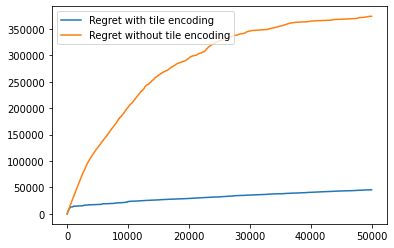

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline 

plt.plot(regrets, label="Regret with tile encoding")
plt.plot(regrets_1, label="Regret without tile encoding")
plt.legend(loc="upper left");

Regret with tile encoding is much lower and algorithm finds better solution faster.

# Implementation without jax. Not recommended  

Below is an implementation of the same algorithm without jax parallelization. Works more than **500** times slower.

In [4]:
import numpy as np
import itertools

class TileEncoder:
    def __init__(self, widths, offsets, ranges, lr=.01):
        
        self.widths = widths
        self.offsets = offsets
        self.ranges = ranges
        self.num_tile_layers = 1


        for w, o in zip(widths, offsets):
            n_layers = np.lcm(o, w)//o
            self.num_tile_layers = max(self.num_tile_layers, n_layers)

        self.l = tuple(range_l_i - offset_i*self.num_tile_layers for (range_l_i, range_r_i), offset_i in zip(self.ranges, self.offsets))
        self.r = tuple(range_r_i + offset_i*self.num_tile_layers for (range_l_i, range_r_i), offset_i in zip(self.ranges, self.offsets))

        self.w = np.random.randn(*((self.num_tile_layers,) + tuple((r_i - l_i)//w_i for r_i, l_i, w_i in zip(self.r, self.l, self.widths))))
        self.N = np.zeros((self.num_tile_layers,) + tuple((r_i - l_i)//w_i for r_i, l_i, w_i in zip(self.r, self.l, self.widths)))

        self.lr = lr
        
    def encode(self, x):
        encoded = []
        for i in range(self.num_tile_layers):
            encoded.append(tuple(
                np.clip(x_j - i*offset_j, a_min=l_j, a_max=r_j).astype(int)//w_j for x_j, offset_j, l_j, r_j, w_j in zip(x, self.offsets, self.l, self.r, self.widths)
            ))
        return encoded

    def calculate_expectation_and_n(self, encoded_x):
        value = 0
        n = 0
        for i, tile_numbers_i in enumerate(encoded_x):
            index = (i,) + tile_numbers_i
            value += self.w[index]
            n += self.N[index]
        return value/len(encoded_x), n

    def update(self, x, g):
        encoded_x = self.encode(x)
        for i, tile_numbers_i in enumerate(encoded_x):
            index = (i,) + tile_numbers_i
            self.w[index] += self.lr * (g - self.calculate_expectation_and_n(encoded_x)[0])
            self.N[index] += 1

    def get_scores(self, lists):
        x_generator = itertools.product(*lists)

        Ns = []
        values = []
        for x in x_generator:
            encoded_x = self.encode(x)
            value_i, n_i = self.calculate_expectation_and_n(encoded_x)
            values.append(value_i)
            Ns.append(n_i)
        sigma_V = np.std(values)
        mu_V = np.mean(values)

        x_generator = itertools.product(*lists)

        scores = []
        for V_i, N_i, x_i in zip(values, Ns, x_generator):
            score_i = (V_i - mu_V)/(sigma_V + 1e-3) + np.sqrt(np.log(1 + sum(Ns))/(1 + N_i))
            scores.append((score_i, x_i))

        return scores


In [5]:
from tqdm import tqdm
from random import choice

widths = (3,4,5)
offsets = (1,1,1)
ranges = ((0,15),)*3

target = (5,4,8)
lists = tuple(tuple(range(*r)) for r in ranges)
encoder = TileEncoder(widths, offsets, ranges)

bandit = Bandit(offsets=target)
regrets = []
regret = 0
key = jax.random.PRNGKey(0)


for t in tqdm(range(100)):
    scores = encoder.get_scores(lists)
    top_n_actions = sorted(scores, key=lambda x: x[0], reverse=True)[:1]
    x = choice(top_n_actions)[1]
    key, another_key = jax.random.split(key)
    g = bandit(key, x)
    encoder.update(x, g)
    regret += g
    regrets.append(regret)

print('RESULTED OPTIMUM', sorted(scores, key=lambda x: x[0], reverse=True)[:5])

100%|██████████| 100/100 [02:03<00:00,  1.24s/it]

RESULTED OPTIMUM [(3.160533821033867, (3, 7, 12)), (3.131947232718871, (3, 3, 5)), (3.11324413622446, (3, 3, 6)), (2.976638345566328, (3, 5, 0)), (2.972180091056398, (1, 14, 14))]
